/ Предварительные замечания \\ \

Абсолютно без какого-либо зазрения совести сообщаю:
датасет я спёрла отсюда https://paperswithcode.com/dataset/oxford-102-flower

Он называется Oxford 102 Flower и представляет собой набор данных классификации изображений, состоящий из 102 категорий цветов. Каждый класс состоит из от 40 до 258 изображений.
Затем я его погуглила и нашла соревнование на кеггле
https://www.kaggle.com/competitions/oxford-102-flower-pytorch

и еще вот это
https://pytorch.org/vision/stable/generated/torchvision.datasets.Flowers102.html

In [1]:
!pip install torchmetrics

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import Subset
from torchmetrics import Accuracy as VAccuracy
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import shutil
import matplotlib.pyplot as plt

In [ ]:
# Вытаскиваю из кеггла в колаб пританцовывая с бубном
!pip install kaggle
import json
token = {"username":"resonansss","key":"aea7746cc9e4244102f6bc268fcaa9e7"}
with open('/content/kaggle.json', 'w') as file:
    json.dump(token, file)

!cp /content/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c oxford-102-flower-pytorch -p /content
!unzip \*.zip

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/flower_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [5]:
transform = Compose(
    [transforms.Resize((224, 224)),
     ToTensor()])

dataset = torch.utils.data.DataLoader(datasets.ImageFolder('/content/flower_data', transform=transform), batch_size=256, shuffle=False)

In [9]:
mean, std = get_mean_and_std(dataset)
print(mean, std)

tensor([0.4356, 0.3777, 0.2879]) tensor([0.2940, 0.2425, 0.2673])


In [6]:
transform = Compose(
    [transforms.Resize((224, 224)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(10),
     ToTensor(),
     Normalize(mean=[0.4851, 0.4566, 0.4066], std=[0.2299, 0.2241, 0.2254])])

In [7]:
transform

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.4851, 0.4566, 0.4066], std=[0.2299, 0.2241, 0.2254])
)

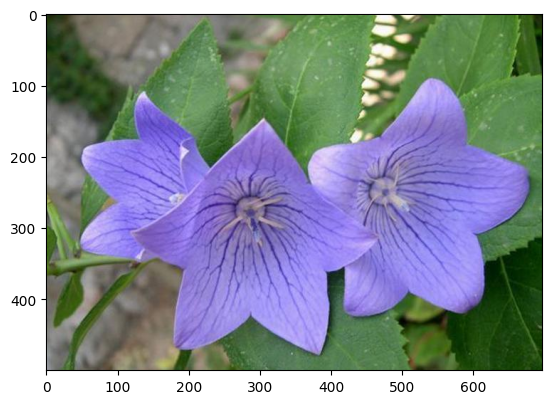

In [8]:
img = Image.open('/content/flower_data/train/19/image_06152.jpg')
plt.imshow(img)
plt.show()

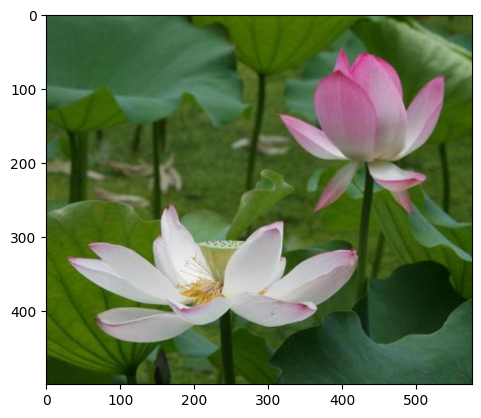

In [9]:
img = Image.open('/content/flower_data/train/78/image_01924.jpg')
plt.imshow(img)
plt.show()

красивое....

In [ ]:
#!ls flower_data/train/12

In [16]:
trainset = torchvision.datasets.ImageFolder(root='/content/flower_data/train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [17]:
valset = torchvision.datasets.ImageFolder(root='/content/flower_data/valid', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=16, shuffle=False)

In [94]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(1, n_epochs + 1):
        # train
        for x_train, y_train in tqdm(trainloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation
        if not epoch % 2:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(valloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [32]:
# class ClassCNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(2, 10, kernel_size=3, padding = 1)
#         self.conv2 = nn.Conv2d(10, 20, kernel_size=5, padding = 1)
#         self.conv3 = nn.Conv2d(20, 50, kernel_size=5, padding = 1)
#         self.pool = nn.MaxPool2d(2)
#         self.flatten = nn.Flatten()

#         self.fc1 = nn.Linear(124 * 124 * 20, 128)
#         self.fc2 = nn.Linear(128, 102)

#         self.dropout = nn.Dropout(0.2)
#         self.relu = nn.ReLU()


#     def forward(self, x):
#         x = self.relu(self.conv1(x))
#         x = self.pool(self.relu(self.conv2(x)))
#         x = self.pool(self.relu(self.conv3(x)))
#         x = self.flatten(x)
#         #x = x.view(-1, 128 * 28 * 28)
#         x = self.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
        # return x

In [95]:
class NN(nn.Module):
  def __init__(self):
      super(NN, self).__init__()

      self.network = nn.Sequential(
          torch.nn.Conv2d(3, 16, kernel_size = 3, padding = 1),
          torch.nn.Conv2d(16, 16, kernel_size = 3, padding = 1),
          torch.nn.ReLU(),
          nn.Conv2d(16, 32, kernel_size = 3, stride = 1, padding = 1),
          nn.Conv2d(32, 32, kernel_size = 3, stride = 1, padding = 1),
          torch.nn.MaxPool2d(2, 2),
          #)

      #self.layer_2 = nn.Sequential(
          torch.nn.Conv2d(32, 64, kernel_size = 3, padding = 1),
          torch.nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          torch.nn.MaxPool2d(2, 2),
          #)

      #self.layer_3 = nn.Sequential(
          torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
          torch.nn.ReLU(),
          torch.nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding = 1),
          torch.nn.ReLU(),
          torch.nn.MaxPool2d(2, 2, padding = 1),
          #)

      #self.flattened_tensor = nn.Flatten()
          torch.nn.Flatten(),

      #self.linear_layer = nn.Sequential(
          torch.nn.Linear(107648, 512),
          torch.nn.ReLU(),
          torch.nn.Linear(512, 256),
          torch.nn.ReLU(),
          torch.nn.Linear(256, 102)
          )

  def forward(self, inp):
    return self.network(inp)

    # def forward(self, inp):
    #   conv_output = self.layer_3(self.layer_2(self.layer_1(inp)))
    #   flattened_output = self.flattened_tensor(conv_output)
      #zddzz
    #   transposed_matrix = torch.transpose(flattened_output, 0, 1)

    #   linear_output = self.linear_layer(transposed_matrix)
    #   return linear_output


In [96]:
model = NN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [98]:
train(model, optimizer, 6)

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2	loss: 4.520755290985107	accuracy: 0.02567237163814181


  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4	loss: 4.117676258087158	accuracy: 0.05256723716381418


  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/410 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6	loss: 3.82680082321167	accuracy: 0.09657701711491443
